## Kaggle Competition Notebook

- Author: Muhammad Hassan Razzaq
- Qualification: PhD (Mechanical Engineering and AI)
- Linkedin: https://www.linkedin.com/in/mhassanrazzaq/

### Title: Survival Rate prediction using Neural Networks in Tensorflow

### 1. Importing Libraries

In [1678]:
!pip install plotly -q

In [1679]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error, r2_score, accuracy_score

In [1680]:
# importing the data
df = pd.read_csv('Titanic competition - train.csv')
df_test = pd.read_csv('Titanic competition - test.csv')

submission = pd.read_csv('Titanic competition - gender_submission.csv')

In [1681]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1682]:
df.shape

(891, 12)

In [1683]:
df_test.shape

(418, 11)

In [1684]:
df.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [1685]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [1686]:
submission.shape

(418, 2)

In [1687]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1688]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


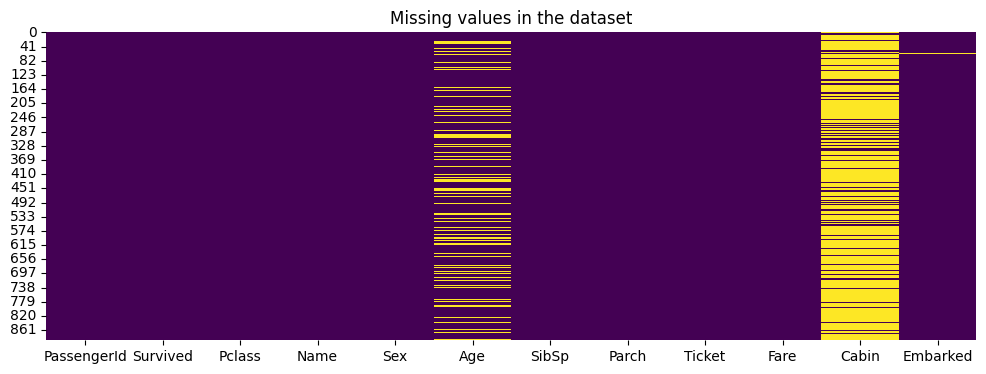

In [1689]:
# plotting the null values
plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing values in the dataset')
plt.show()

In [1690]:
(df.isnull().sum() / len(df_train) * 100).sort_values(ascending=False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

In [1691]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1692]:
categorical_cols = ['Cabin', 'Embarked']
numerical_cols = ['Age']
bool_cols = []

In [1693]:
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
missing_data_cols

['Age', 'Cabin', 'Embarked']

In [1694]:
def impute_categorical_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    le = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = le.fit_transform(X[col])

    if passed_col in bool_cols:
        y = le.fit_transform(y)

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The features '" + passed_col + "' has been imputed with ", round((acc_score * 100), 2), "accuracy\n")
    
    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = le.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

def impute_numerical_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    le = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = le.fit_transform(X[col])

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE= ", mean_absolute_error(y_test, y_pred), "\n")
    print("MSE= ", mean_squared_error(y_test, y_pred), "\n")
    print("RMSE= ", np.sqrt(mean_squared_error(y_test, y_pred)), "\n")
    print("R2= ", r2_score(y_test, y_pred), "\n")
    
    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = le.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_regressor.predict(X)
        
    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

In [1695]:
# remove warning
import warnings
warnings.filterwarnings('ignore')

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values \"", col, "\" :", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%\n")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numerical_cols:
        df[col] = impute_numerical_missing_data(col)
    else:
        pass

(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

Missing Values " Age " : 19.87%

MAE=  9.395475524475524 

MSE=  139.98030910993006 

RMSE=  11.831327444962804 

R2=  0.24499925791514088 

Missing Values " Cabin " : 77.1%

The features 'Cabin' has been imputed with  26.83 accuracy

Missing Values " Embarked " : 0.22%

The features 'Embarked' has been imputed with  89.33 accuracy



PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64

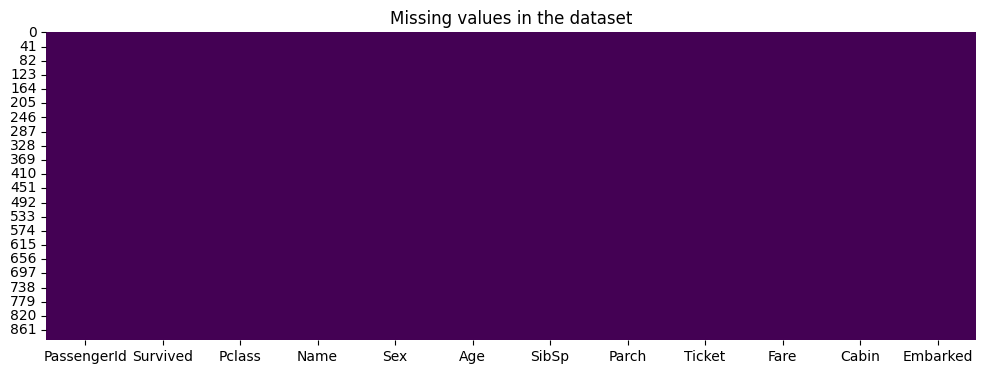

In [1696]:
# plot missing values again
plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing values in the dataset')
plt.show()

In [1697]:
df_test.isnull().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

In [1698]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1699]:
X = df.drop(['Survived', 'Name'], axis=1)
y = df['Survived']

le = LabelEncoder()
encoders = {}

for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype == 'category':
        X[col] = le.fit_transform(X[col])
        encoders[col] = le
    else:
        pass
    


In [1700]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1701]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G6,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G6,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,D56,S


In [1702]:
X.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,1,22.0,1,0,523,7.2500,145,2
1,2,1,0,38.0,1,0,596,71.2833,81,0
2,3,3,0,26.0,0,0,669,7.9250,145,2
3,4,1,0,35.0,1,0,49,53.1000,55,2
4,5,3,1,35.0,0,0,472,8.0500,111,2


In [1703]:
# creating a neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [1704]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3844 - loss: 0.7642 - val_accuracy: 0.6145 - val_loss: 0.6794
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6447 - loss: 0.6637 - val_accuracy: 0.5866 - val_loss: 0.6642
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6528 - loss: 0.6322 - val_accuracy: 0.5866 - val_loss: 0.6557
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6168 - loss: 0.6416 - val_accuracy: 0.5922 - val_loss: 0.6424
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6360 - loss: 0.6210 - val_accuracy: 0.5922 - val_loss: 0.6310
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - loss: 0.6188 - val_accuracy: 0.6145 - val_loss: 0.6161
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.5956 - val_accuracy: 0.6760 - val_loss: 0.5998
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6716 - loss: 0.5874 - val_accuracy: 0.6983 - v

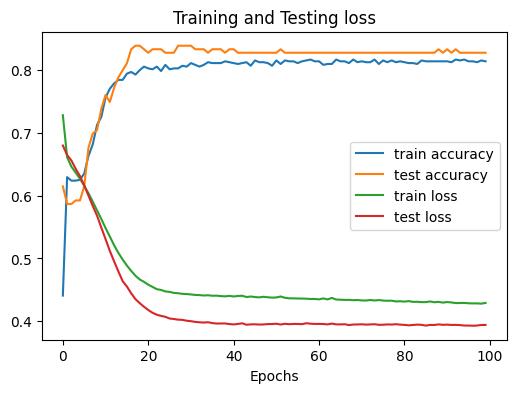

In [1705]:
early_stopping = EarlyStopping(patience=100)

model = tf.keras.models.Sequential([
    (tf.keras.layers.Dense(40, activation='sigmoid', input_shape=(X_train.shape[1],))),
    (tf.keras.layers.Dense(20, activation='sigmoid')),
    (tf.keras.layers.Dense(1, activation='sigmoid'))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1 ,validation_data=(X_test, y_test), callbacks=[early_stopping])

loss= model.evaluate(X_test, y_test, verbose=0)

# Plot the training and testing accuracy, loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel('Epochs')

plt.legend()
plt.title('Training and Testing loss')
plt.show()



In [1706]:
X_train.shape

(712, 10)

Loss:  0.4389249384403229
Accuracy:  0.8212290406227112


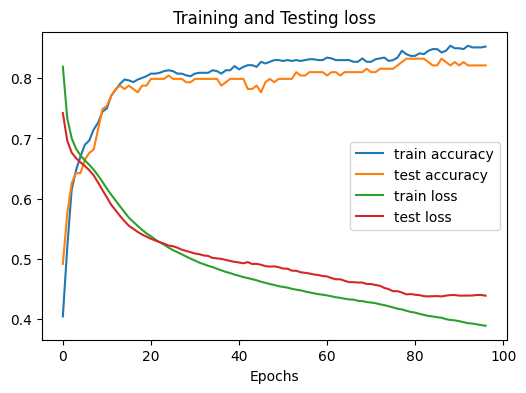

In [1707]:
early_stopping = EarlyStopping(patience=10)

model = tf.keras.models.Sequential([
    (tf.keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],))),
    (tf.keras.layers.Dense(5, activation='relu')),
    (tf.keras.layers.Dense(2, activation='relu')),
    # (tf.keras.layers.Dense(2, activation='relu')),
    # (tf.keras.layers.Dense(8, activation='relu')),
    (tf.keras.layers.Dense(1, activation='sigmoid'))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0 ,validation_data=(X_test, y_test), callbacks=[early_stopping])

loss= model.evaluate(X_test, y_test, verbose=0)

#print the loss and accuracy from history
# print(history.history.keys())
print('Loss: ', loss[0])
print('Accuracy: ', loss[1])


# Plot the training and testing accuracy, loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel('Epochs')

plt.legend()
plt.title('Training and Testing loss')
plt.show()

In [1708]:
X

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,1,22.00,1,0,523,7.2500,145,2
1,2,1,0,38.00,1,0,596,71.2833,81,0
2,3,3,0,26.00,0,0,669,7.9250,145,2
3,4,1,0,35.00,1,0,49,53.1000,55,2
4,5,3,1,35.00,0,0,472,8.0500,111,2
...,...,...,...,...,...,...,...,...,...,...
886,887,2,1,27.00,0,0,101,13.0000,116,2
887,888,1,0,19.00,0,0,14,30.0000,30,2
888,889,3,0,27.75,1,2,675,23.4500,145,2
889,890,1,1,26.00,0,0,8,30.0000,60,0


In [1709]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [1710]:
X.shape

(891, 10)

In [1711]:
X.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1712]:
df_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1713]:
df_test = df_test.drop('Name', axis=1)

In [1714]:
df_test.isnull().sum().sort_values()

PassengerId      0
Pclass           0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
Fare             1
Age             86
Cabin          327
dtype: int64

In [1715]:
missing_data_cols_test = df_test.isnull().sum()[df_test.isnull().sum() > 0].index.tolist()
missing_data_cols_test

['Age', 'Fare', 'Cabin']

In [1716]:
# remove warning
import warnings
warnings.filterwarnings('ignore')

# impute missing values using our functions
for col in missing_data_cols_test:
    print("Missing Values \"", col, "\" :", str(round((df_test[col].isnull().sum() / len(df_test)) * 100, 2))+"%\n")
    if col in categorical_cols:
        df_test[col] = impute_categorical_missing_data(col)
    elif col in numerical_cols:
        df_test[col] = impute_numerical_missing_data(col)
    else:
        pass

(df_test.isnull().sum() / len(df_test) * 100).sort_values(ascending=False)

Missing Values " Age " : 20.57%

MAE=  7.880699134078212 

MSE=  116.04843864068646 

RMSE=  10.772578087008071 

R2=  0.37579028714351315 

Missing Values " Fare " : 0.24%

Missing Values " Cabin " : 78.23%

The features 'Cabin' has been imputed with  59.22 accuracy



Fare           0.239234
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Cabin          0.000000
Embarked       0.000000
dtype: float64

In [1717]:
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

In [1718]:
encoders

{'Sex': LabelEncoder(),
 'Ticket': LabelEncoder(),
 'Cabin': LabelEncoder(),
 'Embarked': LabelEncoder()}

In [1719]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G6,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G6,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,D56,S


In [1720]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,male,22.0,0,0,330911,7.8292,G6,Q
1,893,3,female,38.0,1,0,363272,7.0000,C85,S
2,894,2,male,26.0,0,0,240276,9.6875,G6,Q
3,895,3,male,35.0,0,0,315154,8.6625,C123,S
4,896,3,female,35.0,1,1,3101298,12.2875,D56,S


In [1721]:
# label encoding df_test on the same encoder dictionary
le = LabelEncoder()
encoders_test = {}

for col in df_test.columns:
    if df_test[col].dtype == 'object' or df_test[col].dtype == 'category':
        df_test[col] = le.fit_transform(df_test[col])
        encoders_test[col] = le
    else:
        pass

In [1722]:
# predict df_test
df_test = scaler.transform(df_test)
predictions = model.predict(df_test)



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [1727]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


In [1728]:
y_pred

array([[0.6209197 ],
       [0.19703147],
       [0.19703147],
       [0.9804521 ],
       [0.47720575],
       [0.98617816],
       [0.7391464 ],
       [0.19703147],
       [0.6106327 ],
       [0.9871627 ],
       [0.19703147],
       [0.19703147],
       [0.21073154],
       [0.19703147],
       [0.19703147],
       [0.99937874],
       [0.29052168],
       [0.7234877 ],
       [0.19703147],
       [0.2325941 ],
       [0.19703147],
       [0.46746087],
       [0.36549523],
       [0.19703147],
       [0.19703147],
       [0.19703147],
       [0.19703147],
       [0.19703147],
       [0.22323099],
       [0.4380315 ],
       [0.19703147],
       [0.649681  ],
       [0.19703147],
       [0.53115416],
       [0.19703147],
       [0.22384936],
       [0.24779408],
       [0.60208166],
       [0.996034  ],
       [0.19703147],
       [0.19703147],
       [0.19703147],
       [0.19703147],
       [0.19703147],
       [0.5941155 ],
       [0.19703147],
       [0.19703147],
       [0.197

In [1729]:
y_pred.shape

(179, 1)

In [1726]:
df_test.shape

(418, 10)

In [1724]:
predictions.shape

(418, 1)

In [1730]:
# mapping predictions
predictions = np.round(predictions).astype(int).reshape(-1)

In [1746]:
preds = pd.DataFrame(predictions, columns=['Survived'])

In [1747]:
preds

,Survived
0,0
1,1
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


In [1739]:
df_test_2 = pd.read_csv('Titanic competition - test.csv')
df_test_3 = df_test_2['PassengerId']

In [1740]:
df_test_3

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [1748]:
# concat df_test_3 and preds on the basis of index
submission = pd.concat([df_test_3, preds], axis=1)



In [1749]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [1750]:
# output submission in the form of a csv file
submission.to_csv('Titanic Competition - submission.csv', index=False) 